<a href="https://colab.research.google.com/github/IEwaspbusters/KopuruVespaCompetitionIE/blob/main/Competition_subs/2021-04-28_submit/batch_LARVAE/HEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost Years: Prediction with Cluster Variables and selected Weather Variables (according to Feature importance)

## Import the Data & Modules

In [1]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np
import warnings

# Data Viz -----------------------------------
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # to set figure size when ploting feature_importance
import graphviz # To visualize the Model Tree ::::> 1) conda install -c anaconda graphviz ; 2) conda install python-graphviz

# XGBoost -------------------------------
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn import preprocessing # scaling data
from sklearn.model_selection import GridSearchCV

#Cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from plotnine import *

In [2]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype("string")+HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype("string")+template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

In [3]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_years/WBds03_QUEENtrainYEARS.csv", encoding="utf-8") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_years/WBds03_QUEENpredictYEARS.csv", encoding="utf-8") #2020 prediction df
template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")
den_com = pd.read_excel("../../../Other_open_data/densidad comercial.xlsx")

## Further Clean the Data

In [4]:
# Remove the Municipalities to which we did not assign a Cluster, since there was not reliable data for us to predict 

queen_train = queen_train.loc[~queen_train.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:]
queen_predict = queen_predict.loc[~queen_predict.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:]

# New queen Train dataset

In [5]:
den_com_18= den_com.loc[:,['Código municipio','2018']]
den_com_18.rename({'2018': 'dens_com','Código municipio':'municip_code'}, axis=1, inplace=True)
den_com_18['year_offset']='2018'

den_com_17= den_com.loc[:,['Código municipio','2017']]
den_com_17.rename({'2017': 'dens_com','Código municipio':'municip_code'}, axis=1, inplace=True)
den_com_17['year_offset']='2017'

den_com_19= den_com.loc[:,['Código municipio','2019']]
den_com_19.rename({'2019': 'dens_com','Código municipio':'municip_code'}, axis=1, inplace=True)
den_com_19['year_offset']='2019'

densidad_comercial= den_com_18.append(den_com_17).append(den_com_19)
densidad_comercial['cod_aux']=densidad_comercial.apply(lambda x:'%s_%s' % (x['municip_code'],x['year_offset']),axis=1)


In [6]:
aux_train= queen_train.copy()
aux_train['cod_aux']=aux_train.apply(lambda x:'%s_%s' % (x['municip_code'],x['year_offset']),axis=1)

queen_train_mischief= aux_train.loc[:,
                                    ['municip_code','municip_name','weath_meanTemp',
                                     'population','cod_aux','NESTS']].merge(densidad_comercial, how='left', on='cod_aux')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
queen_train_mischief.drop(['cod_aux','municip_code_y'], axis=1, inplace=True)
queen_train_mischief.rename({'municip_code_x': 'municip_code'}, axis=1, inplace=True)
queen_train_mischief["dens_com"] = queen_train_mischief["dens_com"].apply(lambda x: x.replace(",", "."))


# New queen predict dataset

In [7]:
queen_predict_mischief= queen_predict.loc[:,['municip_code','municip_name','weath_meanTemp','year_offset','population']]
queen_predict_mischief['cod_aux']= queen_predict_mischief.apply(lambda x:'%s_%s' % (x['municip_code'],x['year_offset']),axis=1)
queen_predict_mischief= queen_predict_mischief.merge(densidad_comercial, how='left', on='cod_aux')
queen_predict_mischief.drop(['cod_aux','municip_code_y','year_offset_x','year_offset_y'], axis=1, inplace=True)
queen_predict_mischief.rename({'municip_code_x': 'municip_code'}, axis=1, inplace=True)
queen_predict_mischief["dens_com"] = queen_predict_mischief["dens_com"].apply(lambda x: x.replace(",", "."))


In [8]:
predict_20=queen_predict_mischief.loc[:,['weath_meanTemp', 'population', 'dens_com']]

## Get the Prediction

### Arrange data into a features matrix and target vector

In [9]:
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y = queen_train_mischief.NESTS

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X = queen_train_mischief.loc[:,['weath_meanTemp', 'population', 'dens_com']]


### Scale the Data in order to filter the relevant variables using Feature Importance

#### Arrange data into a features matrix and target vector

In [43]:
# Scale the datasets using MinMaxScaler

X_scaled = preprocessing.minmax_scale(X) # this creates a numpy array
X_scaled = pd.DataFrame(X_scaled,index=X.index,columns=X.columns) # To get the features' name

#### Choose a class of model by importing the appropriate estimator class

In [44]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor(objective="reg:squarederror", random_state=0)

### Use GridSearchCV to find out the best hyperparameters for our XGBoost model with our Fitted Data

In [45]:
# Use GridSearchCV that will automatically split the data and give us the best estimator by:

#1) Establishing hyperparameters to change 
param_grid = {
              "learning_rate": [0.01], 
              "max_depth": [10],
              "gamma" : [0],
              #"max_delta_step" : [3],
              "min_child_weight": [9],
              "subsample": [1],
              "colsample_bytree": [1],
              "reg_lambda" : [0.1],
              "n_estimators": [5000],
              "scale_pos_weight" : [0.1,0.5,1]
              }

warnings.filterwarnings(action='ignore', category=UserWarning)
grid = GridSearchCV(model, param_grid, cv=3)

#2) Fitting the model with our desired data and check for best results
grid.fit(X_scaled, y)

#) Retrieve the summary of GridSearchCV for analysis
print(F"The number homogeneous splits conducted by GridSearchCV are: {grid.n_splits_}.")
print(F"The best hyperparameters found were: {grid.best_params_}.")
print(F"The best score found was: {grid.best_score_}.")

The number homogeneous splits conducted by GridSearchCV are: 3.
The best hyperparameters found were: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 9, 'n_estimators': 5000, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 1}.
The best score found was: -0.09639489772630609.


In [46]:
# Reset warnigns to default (this is used to suppred a warning message from XGBoost model and avoid converting X_train to numpy to keep features name)

warnings.filterwarnings(action='default', category=UserWarning)

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [47]:
# selecting the XGBoost model and fitting with the train data for each cluster

model = grid.best_estimator_
model.fit(X_scaled, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F-Score', ylabel='Feature Importance'>

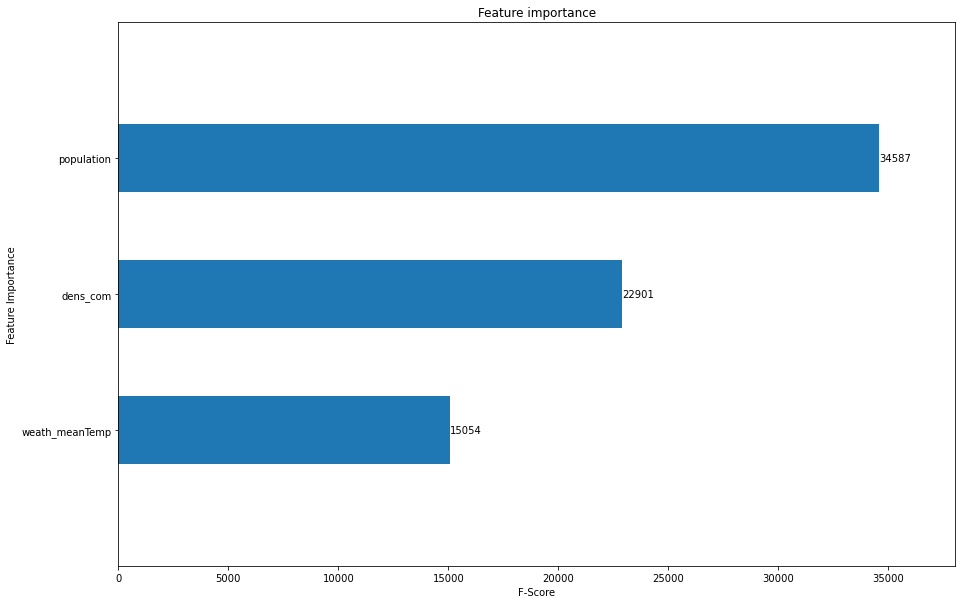

In [48]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

xgb.plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)

<AxesSubplot:>

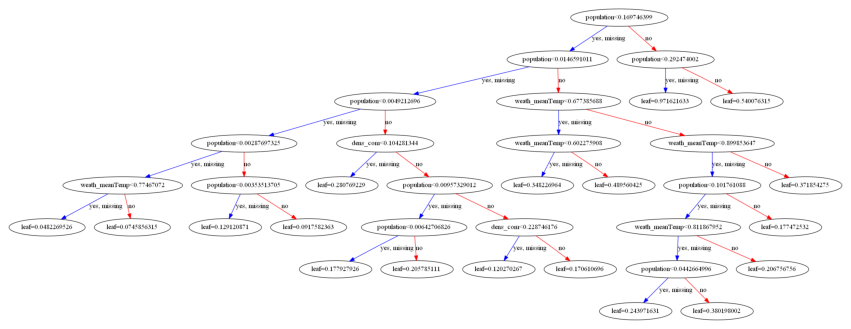

In [49]:
xgb.plot_tree(model)

### Fit the model to your data by calling the `.fit()` method of the model instance

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [50]:
# make a prediction
X_scaled_pred = preprocessing.minmax_scale(predict_20)
queen_predict_mischief['nests_2020'] = model.predict(X_scaled_pred)

C:\Users\pgeir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [51]:
# Create a new DataFrame with the Municipalities to insert manualy

HEX_aux = pd.DataFrame({"CODIGO MUNICIPIO":[48022, 48071, 48088, 48074, 48051, 48020],\
             "NOMBRE MUNICIPIO":["Karrantza Harana/Valle de Carranza","Muskiz","Ubide","Urduña/Orduña","Lanestosa","Bilbao"],\
             "NIDOS 2020":[0,0,1,0,1,0]})

In [52]:
HEX = queen_predict_mischief.loc[:,["municip_code","municip_name","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)
HEX = HEX.append(HEX_aux, ignore_index=True) # Add rows of municipalities to add manually

In [53]:
# Final check

check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2810


'All Municipality Names and Codes to be submitted match the Template'

In [54]:
# reset max_rows to default values (used in function to see which rows did not match template)

pd.reset_option("max_rows")

In [55]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210519_XGyears_NOcluster_PC2_GridSearchCV.csv", index=False)